In [1]:
# Adapted from https://pytorch.org/rl/stable/tutorials/multiagent_competitive_ddpg.html

####################################
# Imports
####################################
import copy
import random
import torch

from matplotlib import pyplot as plt
from tensordict import TensorDictBase

from tensordict.nn import TensorDictModule, TensorDictSequential

from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, RandomSampler, ReplayBuffer

from torchrl.envs import (
    check_env_specs,
    ExplorationType,
    PettingZooEnv,
    RewardSum,
    set_exploration_type,
    TransformedEnv,
    VmasEnv,
)

from torchrl.modules import (
    AdditiveGaussianModule,
    MultiAgentMLP,
    ProbabilisticActor,
    TanhDelta,
)

from torchrl.objectives import DDPGLoss, SoftUpdate, ValueEstimators

from torchrl.record import CSVLogger, PixelRenderTransform, VideoRecorder

In [2]:
####################################
# Constants and Hyperparams
####################################

# Devices
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")
print(device)

# Seed
SEED = 2 # random.randint(0, 2**32 - 1)
print(SEED)
torch.manual_seed(SEED)

# Sampling
N_ITERS = 5000  # Number of sampling and training iterations
frames_per_batch = 1_000  # Number of team frames collected per sampling iteration
total_frames = frames_per_batch * N_ITERS

# Training
BATCH_SIZE = 128  # Number of frames sampled from buffer to train in each optimiser step
lr = 1e-4  # Learning rate
MAX_GRAD_NORM = 1.0  # Maximum norm for the gradients

####################################
# Environment Setup
####################################
SIM_MAX_STEPS = 100  # Environment steps before truncated

N_PURSUERS = 3
N_EVADERS = 1
N_OBSTACLES = 2

# Use VMAS env: offers ~2x speed
base_env = VmasEnv(
    scenario="simple_tag",
    num_envs= frames_per_batch // SIM_MAX_STEPS, # Number of vectorized environments. frames_per_batch collection are divided evenly.
    continuous_actions=True,
    max_steps=SIM_MAX_STEPS,
    device=device,
    seed=SEED,
    # Scenario specific
    num_good_agents=N_EVADERS,
    num_adversaries=N_PURSUERS,
    num_landmarks=N_OBSTACLES,
)

cpu
2


In [3]:
base_env.group_map # Group/team mapping

{'adversary': ['adversary_0', 'adversary_1', 'adversary_2'],
 'agent': ['agent_0']}

In [4]:
print("action_spec:", base_env.full_action_spec)
# print("reward_spec:", base_env.full_reward_spec)
# print("done_spec:", base_env.full_done_spec)
# print("observation_spec:", base_env.observation_spec)

print("\n====================================\n")

print("action_keys:", base_env.action_keys)
# print("reward_keys:", base_env.reward_keys)
# print("done_keys:", base_env.done_keys)

action_spec: Composite(
    adversary: Composite(
        action: BoundedContinuous(
            shape=torch.Size([10, 3, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([10, 3, 2]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([10, 3, 2]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        device=cpu,
        shape=torch.Size([10, 3])),
    agent: Composite(
        action: BoundedContinuous(
            shape=torch.Size([10, 1, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([10, 1, 2]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([10, 1, 2]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        device=cpu,
        shape=torc

In [5]:
# Transform environment to accumulate rewards per team
env = TransformedEnv(
    base_env,
    RewardSum(
        in_keys=base_env.reward_keys,
        reset_keys=["_reset"] * len(base_env.group_map.keys()),
    ),
)

check_env_specs(env) # Perform rollout to ensure Transform performed correctly

# View Example Rollout 

# n_rollout_steps = 5
# rollout = env.rollout(n_rollout_steps)
# print(f"rollout of {n_rollout_steps} steps:", rollout)
# print("Shape of the rollout TensorDict:", rollout.batch_size)

2025-01-27 02:14:02,412 [torchrl][INFO] check_env_specs succeeded!


In [6]:
####################################
# Actor: Policy
####################################


# MultiAgentMLP to map observations -> actions
policy_modules = {}
for group, agents in env.group_map.items():
    share_parameters_policy = True  # Agents are behaviorally homogenous

    policy_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[-1],  # num inputs = observation space of the group
        n_agent_outputs=env.full_action_spec[group, "action"].shape[-1],  # num outputs = action space of the group 
        n_agents=len(agents),  # number of agents in the group
        centralised=False,  # decentralized policies (agents act on local observations only)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=512,
        activation_class=torch.nn.Tanh,
    )

    # Wrap the NN in a TensorDictModule. 
    # The module reads in_keys from a tensordict, feeds them into the NN, and writes output in-place at out_keys
    policy_module = TensorDictModule(
        policy_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "param")],
    ) 
    policy_modules[group] = policy_module

# ProbabilisticActor to build a TanhDelta out of action parameters. 
policies = {}
for group, _agents in env.group_map.items():
    policy = ProbabilisticActor(
        module=policy_modules[group],
        spec=env.full_action_spec[group, "action"],
        in_keys=[(group, "param")],
        out_keys=[(group, "action")],
        distribution_class=TanhDelta,
        distribution_kwargs={
            "low": env.full_action_spec[group, "action"].space.low, # min action: -1 
            "high": env.full_action_spec[group, "action"].space.high, # max action: +1
        },
        return_log_prob=False, # Since DDPG is deterministic
    )
    policies[group] = policy

# AdditiveGaussianModule to make agents explore; adds Gaussian noise
exploration_policies = {}
for group, _agents in env.group_map.items():
    exploration_policy = TensorDictSequential(
        policies[group],
        AdditiveGaussianModule(
            spec=policies[group].spec,
            annealing_num_steps=total_frames // 2,  # Num frames to complete sigma decay
            action_key=(group, "action"),
            sigma_init=0.9,  # Initial standard deviation 
            sigma_end=0.1,  # Final standard deviation (less noise)
        ),
    )
    exploration_policies[group] = exploration_policy

In [7]:
####################################
# Critic: Q-Value
####################################

# MultiAgentMLP to map observations & actions -> values
critics = {} 
for group, agents in env.group_map.items():
    share_parameters_critic = True  # Centralized training 

    # Reads in observation and action entries for each group. 
    # Concatenates them into a new (group, "obs_action") entry.
    cat_module = TensorDictModule(
        lambda obs, action: torch.cat([obs, action], dim=-1),
                                      in_keys=[(group, "observation"), (group, "action")],
                                      out_keys=[(group, "obs_action")],
                                     )
    
    critic_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[-1] + env.full_action_spec[group, "action"].shape[-1], # num inputs = obs + action space 
        n_agent_outputs=1,  # num output: 1 value per agent
        n_agents=len(agents),
        centralised=True, # If False, we create IDDPG (decentralized critic, just like decentralized agent policies)
        share_params=share_parameters_critic,
        device=device,
        depth=2,
        num_cells=512,
        activation_class=torch.nn.Tanh,
    )

    # Wrap the NN in a TensorDictModule.
    # Read in obs-action pairs, output the value in-place.
    critic_module = TensorDictModule(
        critic_net,
        in_keys=[(group, "obs_action")],
        out_keys=[(group, "state_action_value")],
    )

    critics[group] = TensorDictSequential(cat_module, critic_module)  # Run them sequentially 

In [8]:
reset_td = env.reset()
for group, _agents in env.group_map.items():
    pass
    # This code essentially shows that after calling the critic, the obs_action input and state_action_value fields
    # are appended in the TensorDict! We can now retrieve the calculated state_action_value!

    # print(critics[group](policies[group](reset_td))) # Example: run val and policy for group

In [9]:
####################################
# Data Collector
####################################
# Run group policies simultaneously by putting them in sequence.
group_exploration_policy = TensorDictSequential(*exploration_policies.values())

# Data collectors reset the environment, and perform rollout until done state is reached. 
# Repeats until total_frames are collected. 
data_collector = SyncDataCollector(
    env,
    group_exploration_policy,
    device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

####################################
# Replay Buffer
####################################
replay_buffers = {}
memory_size = 1_000_000  # The replay buffer of each group can store this many frames

for group, _agents in env.group_map.items():
    replay_buffer = ReplayBuffer(
        storage=LazyMemmapStorage(memory_size, device=device),  # Store up to 'memory_size' multiagent transitions. 
        sampler=RandomSampler(),
        batch_size=BATCH_SIZE, # Samples this batch size
    )
    replay_buffers[group] = replay_buffer

####################################
# Loss Functions
####################################
gamma = 0.99  # DDPG Discount factor
polyak_tau = 0.005  # DDPG Tau for the soft-update of the target network

losses = {}
for group, _agents in env.group_map.items():
    # Use DDPGLoss class to hide away DDPG math and control flow. 
    loss_module = DDPGLoss(
        actor_network=policies[group],  # Optimize non-explorative policy
        value_network=critics[group],
        delay_value=True,  # Enable usage of target network for this value
        loss_function="l2",
    )
    
    loss_module.set_keys(
        state_action_value=(group, "state_action_value"),
        reward=(group, "reward"),
        done=(group, "done"),
        terminated=(group, "terminated"),
    )

    loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma) # One-step TD Learning

    losses[group] = loss_module

target_updaters = {} # Target network
optimisers = {} # Adam Optimiser
for group, loss in losses.items():
    target_updaters[group] =  SoftUpdate(loss, tau=polyak_tau)
    optimisers[group] = {
        "loss_actor": torch.optim.Adam(loss.actor_network_params.flatten_keys().values(), lr=lr),
        "loss_value": torch.optim.Adam(loss.value_network_params.flatten_keys().values(), lr=lr),
    }

In [10]:
####################################
# Training Helper Function
####################################
def process_batch(batch: TensorDictBase) -> TensorDictBase:
    """
    If (group, "terminated") and (group, "done") keys don't exist, create them.
    This is needed to maintain same batch shape for loss calculation. 
    """
    for group in env.group_map.keys():
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)

        nested_done_key = ("next", group, "done")
        if nested_done_key not in keys:
            batch.set(
                nested_done_key,
                batch.get(("next", "done")).unsqueeze(-1).expand((*group_shape, 1)),
            )

        nested_terminated_key = ("next", group, "terminated")
        if nested_terminated_key not in keys:
            batch.set(
                nested_terminated_key,
                batch.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand((*group_shape, 1)),
            )
    return batch

In [11]:
####################################
# Training Variables: these vars don't change across re-training runs. 
####################################
episode_reward_mean_map = {group: [] for group in env.group_map.keys()}
curr_groups = copy.deepcopy(env.group_map)

In [12]:
####################################
# Main Training Loop
####################################
ITER_STOP_TRAIN_EVADERS = N_ITERS // 2
N_OPTIMIZER_STEPS = 100  # Number of optimization steps per training iteration

# Create a new data_collector for retraining
data_collector = SyncDataCollector(
    env,
    group_exploration_policy,
    device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

# Training/collection iterations
for i, batch in enumerate(data_collector):
    current_frames = batch.numel() # Number of elements in batch
    batch = process_batch(batch)  # Expand 'done' keys if needed (its needed lol)

    # Train each group
    for group in curr_groups.keys():
        # Exclude data from other groups
        group_batch = batch.exclude(*[key for _group in env.group_map.keys()
                                      if _group != group
                                      for key in [_group, ("next", _group)]]) 
        
        group_batch = group_batch.reshape(-1)  # Make batch one-dimensional
        replay_buffers[group].extend(group_batch) # Add batch to Replay Buffer

        for _ in range(N_OPTIMIZER_STEPS):
            subdata = replay_buffers[group].sample() # sample from Replay Buffer
            loss_vals = losses[group](subdata) # Generates loss for every sample in the batch (has shape BATCH_SIZE)

            for loss_name in ["loss_actor", "loss_value"]:
                loss = loss_vals[loss_name]
                optimiser = optimisers[group][loss_name]

                # Update the weights
                optimiser.zero_grad()

                loss.backward() # Backprop the loss
                # Optional: clip huge gradients
                params = optimiser.param_groups[0]["params"]
                torch.nn.utils.clip_grad_norm_(params, MAX_GRAD_NORM) 

                optimiser.step()

            # Soft-update the target network
            target_updaters[group].step()

        # Exploration sigma anneal update
        exploration_policies[group][-1].step(current_frames) # Step current_frames times



    # Stop Training Evader
    if i == ITER_STOP_TRAIN_EVADERS:
        if 'agent' in curr_groups.keys():
            del curr_groups["agent"]

    # Logging
    for group in env.group_map.keys():
        episode_reward_mean = (
            batch.get(("next", group, "episode_reward"))[
                batch.get(("next", group, "done"))
            ]
            .mean()
            .item()
        )
        episode_reward_mean_map[group].append(episode_reward_mean)
    if (i+1) % 10 == 0:
        print("Iteration:", i+1, " | Reward:", episode_reward_mean_map['adversary'][-1])

Iteration: 10  | Reward: 0.0
Iteration: 20  | Reward: 89.0
Iteration: 30  | Reward: 45.0
Iteration: 40  | Reward: 5.0
Iteration: 50  | Reward: 4.0
Iteration: 60  | Reward: 128.0
Iteration: 70  | Reward: 121.0
Iteration: 80  | Reward: 173.0
Iteration: 90  | Reward: 165.0
Iteration: 100  | Reward: 141.0
Iteration: 110  | Reward: 162.0
Iteration: 120  | Reward: 12.0
Iteration: 130  | Reward: 16.0
Iteration: 140  | Reward: 24.0
Iteration: 150  | Reward: 12.0
Iteration: 160  | Reward: 10.0
Iteration: 170  | Reward: 24.0
Iteration: 180  | Reward: 10.0
Iteration: 190  | Reward: 30.0
Iteration: 200  | Reward: 15.0
Iteration: 210  | Reward: 24.0
Iteration: 220  | Reward: 34.0
Iteration: 230  | Reward: 25.0
Iteration: 240  | Reward: 18.0
Iteration: 250  | Reward: 9.0
Iteration: 260  | Reward: 27.0
Iteration: 270  | Reward: 40.0
Iteration: 280  | Reward: 38.0
Iteration: 290  | Reward: 12.0
Iteration: 300  | Reward: 16.0
Iteration: 310  | Reward: 13.0
Iteration: 320  | Reward: 20.0
Iteration: 330 

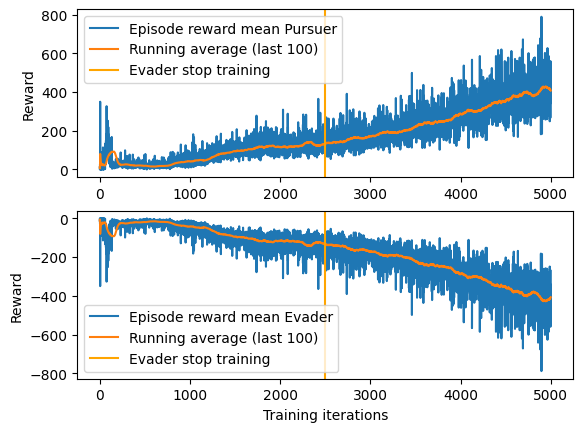

In [34]:
####################################
# Plot Results
####################################

# Calculate running average for plot
def running_average_last_100(data):
    running_averages = {'agent': [], 'adversary': []}
    for group in ['agent', 'adversary']:
        for i in range(len(data[group])):
            start_index = max(0, i - 99)  # Start at most 100 values back
            window = data[group][start_index:i + 1]  # Get the last 100 or fewer values
            running_averages[group].append(sum(window) / len(window))  # Calculate average
    return running_averages

running_averages = running_average_last_100(episode_reward_mean_map)

# Plot the results
fig, axs = plt.subplots(2, 1)
for i, group in enumerate(env.group_map.keys()):
    if group == "adversary":
        legend_name = "Pursuer"
    else:
        legend_name = "Evader"

    axs[i].plot(episode_reward_mean_map[group], label=f"Episode reward mean {legend_name}")
    axs[i].plot(running_averages[group], label=f"Running average (last 100)")
    axs[i].set_ylabel("Reward")
    axs[i].axvline(
        x=ITER_STOP_TRAIN_EVADERS,
        label="Evader stop training",
        color="orange",
    )
    axs[i].legend()
axs[-1].set_xlabel("Training iterations")
plt.show()

In [35]:
####################################
# Save and Load Model
####################################
file_name = "MADDPG_2depth_512cell_5000iter-5"

def save():
    torch.save(policies['agent'][0].module.state_dict(), 'MADDPG/Models/policy_agent_' + file_name + '.pth')
    torch.save(policies['adversary'][0].module.state_dict(), 'MADDPG/Models/policy_adv_' + file_name + '.pth')
    torch.save(critics['agent'][1].module.state_dict(), 'MADDPG/Models/critic_agent_' + file_name + '.pth')
    torch.save(critics['adversary'][1].module.state_dict(), 'MADDPG/Models/critic_adv_' + file_name + '.pth')
    

def load(): 
    policies['agent'][0].module.load_state_dict(torch.load('MADDPG/Models/policy_agent_' + file_name + '.pth'))
    policies['adversary'][0].module.load_state_dict(torch.load('MADDPG/Models/policy_adv_' + file_name + '.pth'))
    critics['agent'][1].module.load_state_dict(torch.load('MADDPG/Models/critic_agent_' + file_name + '.pth'))
    critics['adversary'][1].module.load_state_dict(torch.load('MADDPG/Models/critic_adv_' + file_name + '.pth'))

# SAVE AND LOAD HERE
# save()
# print("saved")


# load()
# print("loaded")



In [37]:
####################################
# Rollout and Render!
####################################

windows = False
folder_name = "MADDPG"

if windows:
    saveLoc = "C:\\Users\\dfc49\\Desktop\\Research\\MPE_Testing\\Videos"
else:
    saveLoc = "/Users/dchang/Desktop/Princeton/Senior Year/Research/MPE_Testing"

video_logger = CSVLogger(folder_name, saveLoc, video_format="mp4")
env_with_render = TransformedEnv(env.base_env, env.transform.clone())
env_with_render = env_with_render.append_transform(
    PixelRenderTransform(
        out_keys=["pixels"],
        preproc=lambda x: x.copy(),
        as_non_tensor=True,
        mode="rgb_array", # must be this to record
    )
)
env_with_render = env_with_render.append_transform(VideoRecorder(logger=video_logger, tag=file_name)
                                                   
                                                   )
with set_exploration_type(ExplorationType.DETERMINISTIC):
    print("Rendering rollout...")
    env_with_render.rollout(100, policy=group_exploration_policy)

print("Saving the video...")
env_with_render.transform.dump()
print("Saved! Saved to ", saveLoc)

Rendering rollout...
Saving the video...
Saved! Saved to  /Users/dchang/Desktop/Princeton/Senior Year/Research/MPE_Testing
